# Transform target Density according to xyz permutation

In [63]:
from scf_guess_tools import Backend, load, calculate
from pyscf.gto import Mole
import glob, os, sys
import numpy as np

In [64]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap
sys.path.append(os.path.join(".."))
from utils import  flatten_triang, unflatten_triang, plot_fock_comparison, density_from_fock

In [65]:
import os

train_test_seed = 42
source_path = '../../datasets/QM9/xyz_c7h10o2/'
all_file_paths = glob.glob(os.path.join(source_path, '*.xyz'))
n_elec = 19
len(all_file_paths)
# /home/etschgi1/REPOS/Masterarbeit/scripts/6-31g_2df_p_custom_nwchem.gbs
BASIS_PATH = "../../scripts/6-31g_2df_p_custom_nwchem.gbs"
if not os.path.exists(BASIS_PATH):
    raise FileNotFoundError(f"Basis set file not found at {BASIS_PATH}")

In [66]:
# test on random mol! 

xyz_file = all_file_paths[0]
mol_name = os.path.basename(xyz_file).strip()
method = "dft"
functional = "b3lypg"
guess = "minao"
backend = "pyscf"
cache_path = "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)/pyscf"
ret = density_fock_overlap(filepath = xyz_file,
                                filename = mol_name,
                                method = method,
                                basis = None,
                                functional = functional,
                                guess = guess,
                                backend = backend,
                                cache = cache_path)
# print("\n".join([xyz_file, mol_name, method, "", functional, guess, backend, cache_path]))

fock_test = ret[1]
ref_density_test = ret[0]
overlap_test = ret[2]

- test sim and comp for sanity!

In [67]:
backend = Backend.PY
mol = load(xyz_file, backend=backend)

wf = calculate(mol, BASIS_PATH, "minao", "dft", "b3lypg", cache=False)


Using basis from ../../scripts/6-31g_2df_p_custom_nwchem.gbs


converged SCF energy = -423.189586403783


In [68]:
fock_calc = wf.fock().numpy
density_calc = wf.density().numpy
overlap_calc = wf.overlap().numpy

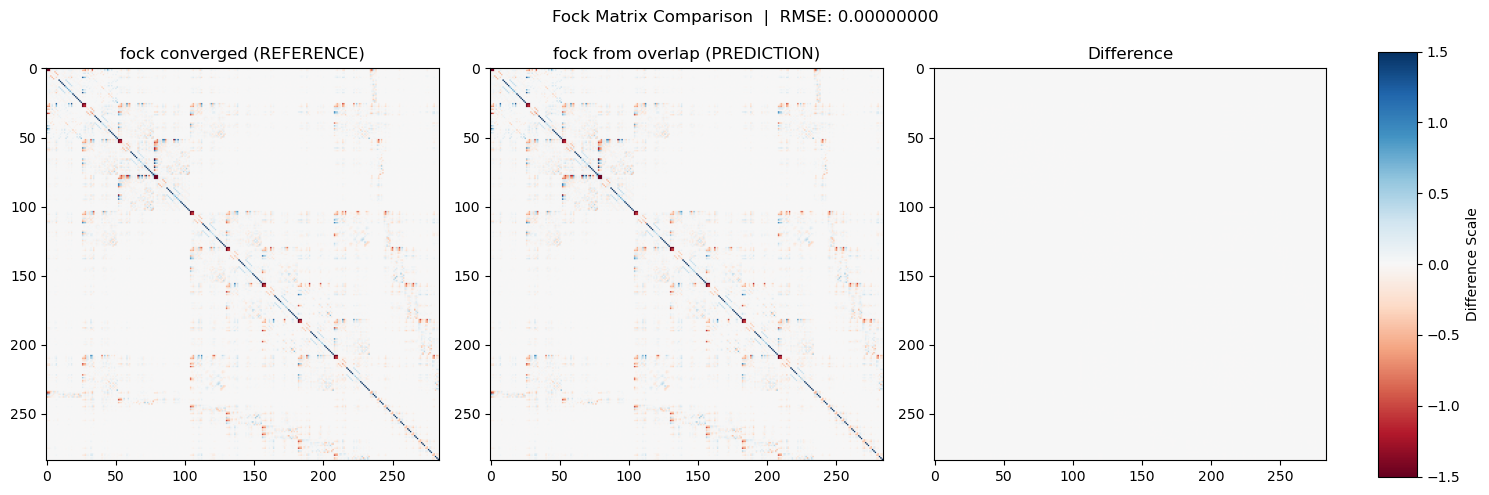

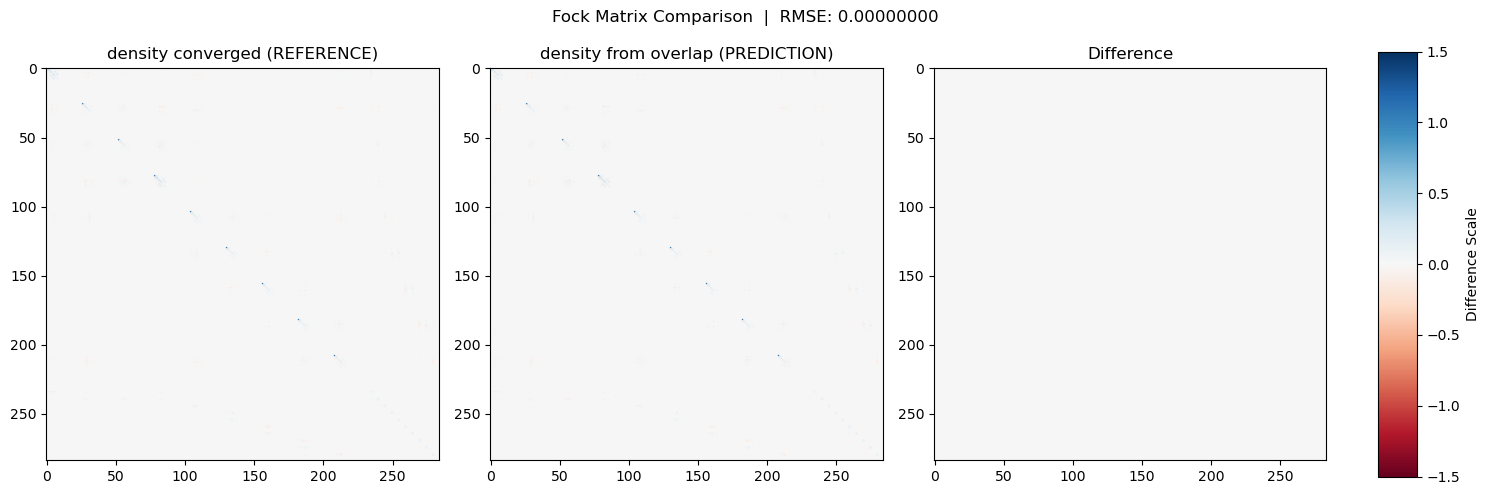

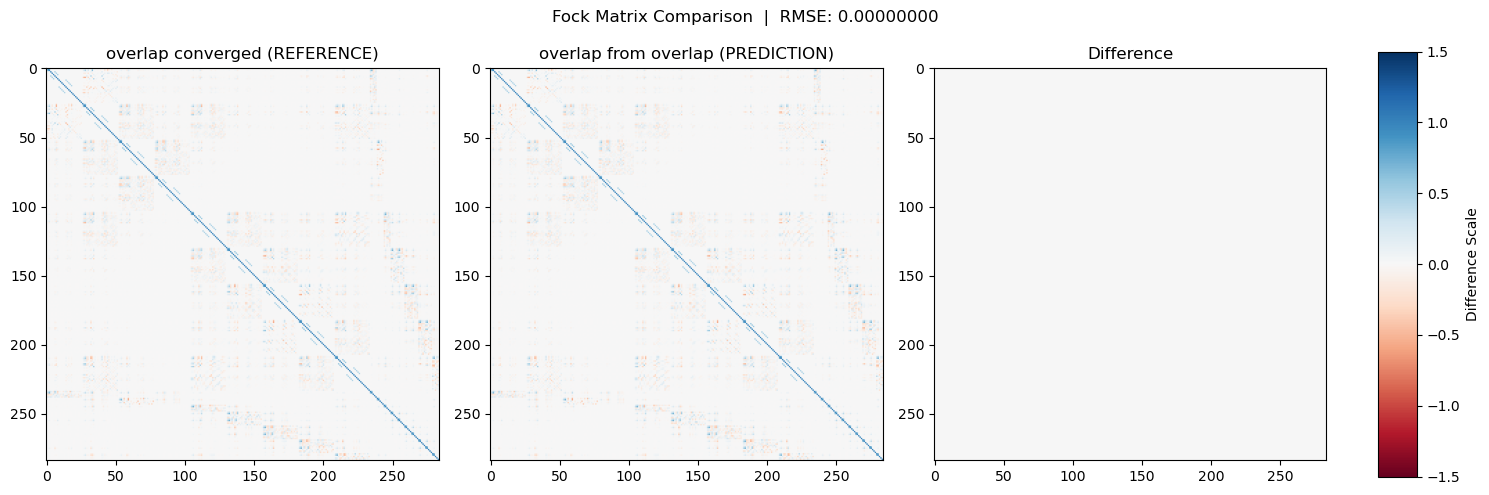

In [69]:
# compare everything!
size = fock_calc.shape[0]
plot_fock_comparison(fock_calc, fock_test.numpy, size, "fock")
plot_fock_comparison(density_calc, ref_density_test.numpy, size, "density")
plot_fock_comparison(overlap_calc, overlap_test.numpy, size, "overlap")

Ok we got the same things! 
Now we need to transform the output after Sim to new ordering! 

In [70]:
xyz_file_reordered = xyz_file.replace("xyz_c7h10o2", "xyz_c7h10o2_sorted")

In [71]:
# we calculate new! 
mol = load(xyz_file_reordered, backend=Backend.PY)

wf = calculate(mol, BASIS_PATH, "minao", "dft", "b3lypg", cache=False)
fock_calc = wf.fock().numpy
density_calc = wf.density().numpy
overlap_calc = wf.overlap().numpy

Using basis from ../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.189586403782


In [72]:
wf.native.cycles

11

In [73]:
def get_reordering(xyz_old, xyz_new): 
    """
    Get the reordering of the atoms in the new xyz xyz_file compared to the old one.
    Indices in list are the indices of the old xyz xyz_file! 
    """
    # read in the old and new xyz files
    with open(xyz_old, 'r') as f:
        old_lines = f.readlines()
    with open(xyz_new, 'r') as f:
        new_lines = f.readlines()
    
    nr_atoms = int(old_lines[0].strip())

    # get the atom names and coordinates from the old and new xyz files
    old_atoms = [line.split() for line in old_lines[2:nr_atoms+2]]
    new_atoms = [line.split() for line in new_lines[2:nr_atoms+2]]
    
    # get the reordering of the atoms
    reordering = [old_atoms.index(atom) for atom in new_atoms]
    assert len(reordering) == len(new_atoms), "Reordering length does not match new atom length"
    assert len(set(reordering)) == len(reordering), "Reordering contains duplicate indices"
    return reordering

def reorder_matrix(mat: np.ndarray,
                   reordering: list[int],
                   mol) -> np.ndarray:
    """
    Reorder an AO-based square matrix in atom blocks.

    Parameters
    ----------
    mat : (M, M) array
        The original AO matrix (M = total number of AOs).
    reordering : length-N_atoms list
        Each entry j is the index of the *old* atom that should
        move to new atom-position j.
    mol : pyscf.gto.Mole
        A PySCF molecule, used to get `mol.ao_labels()` and thus
        recover how many AOs live on each atom in the old ordering.

    Returns
    -------
    mat_new : (M, M) array
        The same matrix, but with atom-blocks permuted according
        to `reordering`.
    """
    # 1) Group AO indices by old-atom
    labels = mol.ao_labels()  # e.g. ["2 O 1s", "2 O 2s", "3 C 1s", ...]
    old2aos: dict[int, list[int]] = {}
    for ao_idx, lab in enumerate(labels):
        atom_idx = int(lab.split()[0])   # PySCF labels are 1-based
        old2aos.setdefault(atom_idx, []).append(ao_idx)

    # 2) Build new AO ordering by flattening blocks in the new atom order
    new_order = []
    for new_atom in range(len(reordering)):
        old_atom = reordering[new_atom]
        new_order.extend(old2aos[old_atom])

    # 3) Permute both axes
    mat_new = mat[np.ix_(new_order, new_order)]
    return mat_new

def reorder_Matrix_using_xyz_perm(mat: np.ndarray,
                                  xyz_old: str,
                                  xyz_new: str,
                                  mol) -> np.ndarray:
        reordering = get_reordering(xyz_old, xyz_new)
        return reorder_matrix(mat, reordering, mol)

In [74]:
reordering = get_reordering(xyz_file, xyz_file_reordered)

In [89]:
mol = load(xyz_file_reordered, backend=Backend.PY, basis=BASIS_PATH)

In [90]:
fock_reordered = reorder_matrix(fock_test.numpy, reordering, mol.native)
overlap_reordered = reorder_matrix(overlap_test.numpy, reordering, mol.native)
density_reordered = reorder_matrix(ref_density_test.numpy, reordering, mol.native)

In [91]:
print(np.allclose(fock_reordered, fock_calc))
print(np.allclose(overlap_reordered, overlap_calc))
print(np.allclose(density_reordered, density_calc))

True
True
True


In [92]:
# try density from fock
n_elec = mol.native.nelectron // 2 # only alpha
res = density_from_fock(fock_reordered, overlap_reordered, n_elec)

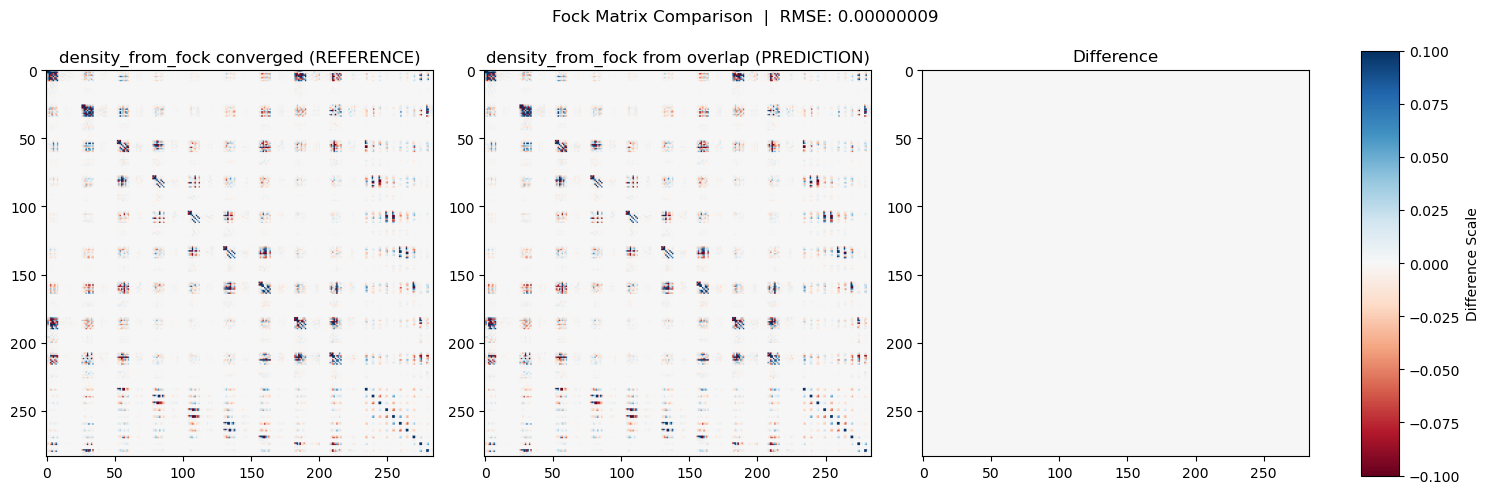

False

In [93]:
plot_fock_comparison(res, 2*density_reordered, size, "density_from_fock", vmax=0.1)
np.allclose(res, density_reordered)

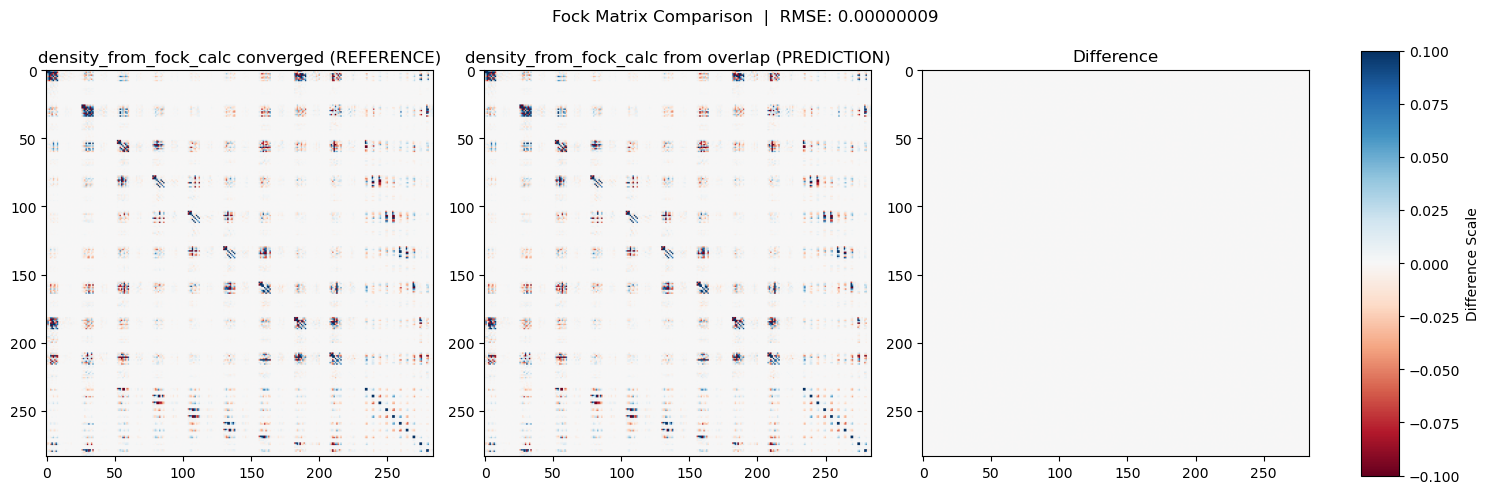

In [79]:
density_reconstruct_from_calc = density_from_fock(
    fock_calc, overlap_calc, n_elec
)
plot_fock_comparison(density_reconstruct_from_calc, 2*density_calc, size, "density_from_fock_calc", vmax=0.1)

In [80]:
from pyscf import scf
mol_reordered = load(xyz_file_reordered, Backend.PY)


# new calc with guess density
# Use the custom basis set file by specifying it when building the molecule
mol = load(xyz_file_reordered, Backend.PY, basis=BASIS_PATH)
wf = scf.RKS(mol.native)
wf.xc = "b3lypg"
wf.kernel(dm0=density_reconstruct_from_calc)
density_native = wf.make_rdm1()

converged SCF energy = -423.189586403859


In [81]:
wf.cycles

4

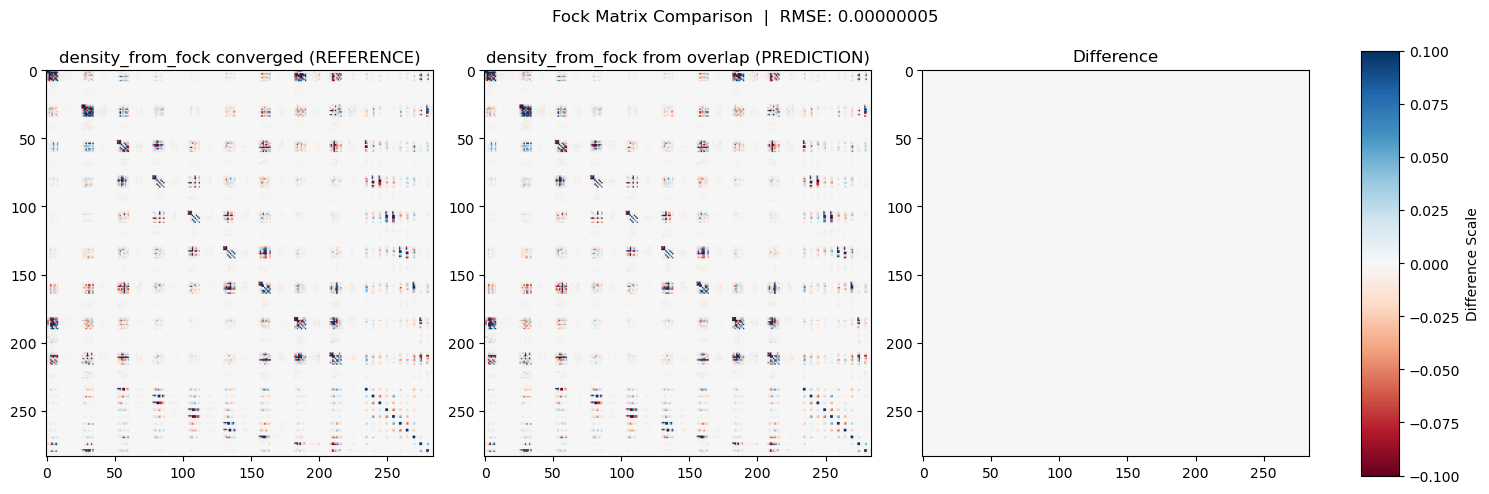

In [82]:
plot_fock_comparison(density_native, density_reconstruct_from_calc, size, "density_from_fock", vmax=0.1)